In [1]:
import os
import numpy as np
import itertools


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Dense, Input, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_DIR = './data'
GLOVE_DIR = os.path.join(DATA_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 15
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2


### Loading the data

In [3]:
data = []  # list of text samples
texts = []
labels = []

for name in ['yelp_labelled.txt', 'imdb_labelled.txt', 'amazon_cells_labelled.txt']:
    path = os.path.join(DATA_DIR, name)
    with open(path) as f:
        text = f.read()
        texts.extend([d.split('\t')[0] for d in [d for d in text.split('\n')] if len(d) > 0])
        labels.extend([int(d.split('\t')[1]) for d in [d for d in text.split('\n')] if len(d) > 0])

In [4]:
texts = np.array(texts)
labels = np.array(labels).astype(np.uint8)

### Basic Text cleaning and stop words removal. 

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /home/faisal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import re
from nltk.tokenize import WhitespaceTokenizer

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    return WhitespaceTokenizer().tokenize(text)

tkns = list(map(text_prepare, texts))


In [7]:
counts = []
for tkn in tkns:
    counts.append(len(tkn))

In [8]:
print ("Average sequence length ", sum(counts)/len(counts))

Average sequence length  11.796333333333333


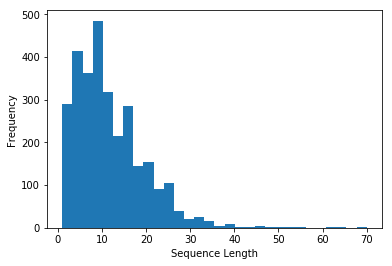

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(counts, 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
# plt.axis([0, 1200, 0, 8000])
plt.show()

In [10]:
cleaned_text = [' '.join(tkn) for tkn in tkns]

### Text to integer indices

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleaned_text)
sequences = tokenizer.texts_to_sequences(cleaned_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

clabels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 5374 unique tokens.
Shape of data tensor: (3000, 15)
Shape of label tensor: (3000,)


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
clabels = clabels[indices]

num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
Y_train = clabels[:-num_validation_samples]
# Non-hot-encoded labels for sklearn GridSearchCV because it does the hot encoding internally. 
Y_train_orig = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = clabels[-num_validation_samples:]


In [13]:
print (f"\t  Positive (+ve) examples in training {Y_train[:, 1].nonzero()[0].shape}.\n \
         Negative examples in training {Y_train[:, 0].nonzero()[0].shape}.\n \
         Positive examples in validation {Y_val[:, 1].nonzero()[0].shape}.\n \
         Negative examples in validation {Y_val[:, 0].nonzero()[0].shape}.")

	  Positive (+ve) examples in training (1195,).
          Negative examples in training (1205,).
          Positive examples in validation (305,).
          Negative examples in validation (295,).


In [14]:
neg_samples = np.random.choice(Y_train[:, 0].nonzero()[0], 500)
pos_samples = np.random.choice(Y_train[:, 1].nonzero()[0], 500)


In [15]:
X_train_small = X_train[np.concatenate((neg_samples, pos_samples))]
Y_train_small = Y_train_orig[np.concatenate((neg_samples, pos_samples))]

### Load pre-existing word embedding the word embeddings

In [16]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### Our word integer index as look-up in the embedding matrix

In [17]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


### Build the Model

In [18]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def build_model(lstm_units=128,
                dropout=0.5,
                recurrent_dropout=0.2,
                optimizer='rmsprop'):
    
    print (f"Building model with lstm_units {lstm_units} dropout {dropout} recurrent_dropout {recurrent_dropout} optimizer {optimizer}")
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    X = SpatialDropout1D(0.4)(embedded_sequences)
    X = LSTM(lstm_units, dropout=dropout, recurrent_dropout=0.2)(X)
    X = Dense(2, activation='softmax')(X)

    model = Model(sequence_input, X)
    
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
model = KerasClassifier(build_fn=build_model,
                        epochs=10, 
                        batch_size=5,
                        verbose=0)

param_grid = {'lstm_units': [64, 128, 256],
              'dropout' : [0.2,  0.5],
              'recurrent_dropout' : [0.2, 0.5],
              'optimizer':('rmsprop','adam'),
              'epochs':[10, 30],
              'batch_size':[32, 64]}

grid = GridSearchCV(model,
                    param_grid=param_grid,
                    return_train_score=True,
                    scoring=['precision_macro','recall_macro','f1_macro'],
                    refit='precision_macro')

grid_results = grid.fit(X_train_small, Y_train_small)

print('Parameters of the best model: ')
print(grid_results.best_params_)

Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 64 dropout 0.2 recurrent_dropout 0.5 o

Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 256 dropout 0.5 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 64 dropout 0.5 recurrent_dropo

Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer rmsprop
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.2 optimizer adam
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 128 dropout 0.2 recurrent_dropout 0.5 optimizer adam
Building model with lstm_units 256 dropout 0.2 recurrent_dropout 0.2 optimizer rmsprop
Building model with lstm_units 256 dropout 0.2 recurrent_drop

In [ ]:
grid_results